<a href="https://colab.research.google.com/github/angelinakhatiwada/Urban-Sound-Classification/blob/main/FNN_RNN_CNN_Mels_MFCCs_Chroma_(480).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Sound Classification

## Classification

### Mels, MFCCS, Chroma 480



In [123]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

from sklearn.metrics import classification_report, confusion_matrix
import os

import pickle

In [2]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, MaxPool2D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical 

### Data import from pickle

In [105]:
metadata = pd.read_csv("UrbanSound8K.csv")
print(metadata.shape)
metadata.head(5)

(8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
with open('features_mfcc_mels_chroma_480.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
data.head()

,shape,label,fold,file_name,sample
0,"(1, 480)",3,5,100032-3-0-0.wav,"[-275.1181945800781, 119.9420166015625, -98.53..."
1,"(1, 480)",2,5,100263-2-0-117.wav,"[-500.94219970703125, 185.2790985107422, -86.7..."
2,"(1, 480)",2,5,100263-2-0-121.wav,"[-531.3129272460938, 187.2084197998047, -70.58..."
3,"(1, 480)",2,5,100263-2-0-126.wav,"[-476.6883544921875, 160.30865478515625, -62.9..."
4,"(1, 480)",2,5,100263-2-0-137.wav,"[-521.3388671875, 185.5974578857422, -82.17254..."


In [5]:
data_final = list(data['sample'])
data_final = pd.DataFrame(data_final)
data_cols = data_final.columns
data_final['label'] = data['label']
data_final['fold'] = data['fold']

print('working dataframe\'s shape:', data_final.shape)


working dataframe's shape: (8732, 482)


In [6]:
dummies = pd.get_dummies(data_final['label']).rename(columns=lambda x: 'label_' + str(x))
data_final = pd.concat([data_final, dummies], axis=1)
data_final.drop(['label'], inplace=True, axis=1)
data_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,fold,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9
0,-275.118195,119.942017,-98.532860,-66.605484,-42.486420,0.402131,-28.352808,-5.509757,10.228971,4.993427,15.709276,0.217791,-2.471627,-1.309020,-9.596347,0.060245,3.033216,1.275356,-5.545012,-10.447481,-6.123017,-1.195621,0.284951,4.162706,-6.063683,-9.491202,2.130976,4.013351,-6.147309,-2.467670,-1.218678,-3.460061,1.996488,1.482269,-4.421334,-3.871776,0.260201,6.499504,1.660284,1.564348,...,0.538574,0.259776,0.398686,0.39761,0.288206,0.218016,0.170305,0.180948,0.226251,0.294747,0.368408,0.485800,0.599721,0.819157,1.0,1.0,1.00000,1.000000,1.0,1.0,0.597305,0.508665,0.569079,0.574369,0.396972,0.32768,0.416034,0.737669,1.0,5,0,0,0,1,0,0,0,0,0,0
1,-500.942200,185.279099,-86.730118,50.013321,9.129330,22.648664,-3.653800,12.262982,7.696915,-6.468750,16.996271,-6.642486,1.505258,9.502500,0.755485,2.961403,2.782999,8.564540,-1.573582,1.753064,6.427263,-0.822553,2.408933,-0.816355,2.321890,3.440592,1.043989,3.781467,2.287611,1.740997,-1.506974,-1.861573,0.376792,-3.290516,-1.969586,-1.592512,0.556584,0.477218,-0.363666,0.932288,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.961986,1.000000,0.999780,1.0,1.0,1.00000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,5,0,0,1,0,0,0,0,0,0,0
2,-531.312927,187.208420,-70.588692,40.575821,9.024836,18.465755,6.274604,15.512786,9.650081,-7.147046,16.225380,-5.734972,-0.911098,5.604235,0.852125,7.364156,0.342053,7.231574,0.229825,-2.651671,1.645591,-4.319296,6.057637,3.671880,4.389508,3.743122,0.206922,3.164777,-3.003430,1.009504,-0.751186,-0.311575,0.297865,-3.360517,1.442541,-0.984575,2.384526,-0.365945,-3.865469,-0.727367,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.95746,0.994274,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,5,0,0,1,0,0,0,0,0,0,0
3,-476.688354,160.308655,-62.986355,50.751179,-0.195573,32.776165,-17.510294,24.728090,-3.879378,-1.768039,14.019302,-11.229858,6.296789,1.147051,12.407727,-3.614734,8.199722,0.751775,-3.906926,6.736926,-0.592982,5.543138,0.663373,2.663424,-3.293756,1.837676,0.527540,-4.162113,3.827827,-4.169458,1.370453,-3.353100,-1.000650,-1.027938,-3.675885,-0.088971,-5.702344,1.879102,-1.422119,3.508478,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,5,0,0,1,0,0,0,0,0,0,0
4,-521.338867,185.597458,-82.172546,46.633289,11.783382,23.567127,4.274833,13.634862,6.119978,-2.869653,18.096880,-7.267805,-2.843901,6.918786,2.052115,6.288871,-0.932113,10.584879,1.575116,-1.291165,3.127109,-5.594441,2.927179,3.906716,4.781282,2.074596,0.246946,3.024389,-1.439145,0.979230,-1.051741,-0.335070,2.438925,0.440893,1.619861,-2.693956,-0.055594,-2.085963,-1.794348,2.859665,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,5,0,0,1,0,0,0,0,0,0,0


In [7]:
def df_transform(fold):
  X_fold_df = data_final[data_final['fold'].isin(fold)]
  X = X_fold_df.iloc[:, 0:480].to_numpy()
  y = X_fold_df.iloc[:, 481:5491].to_numpy()

  return X, y

In [199]:
X_train, y_train = df_transform(['1','2','3','4','6'])
X_train.shape, y_train.shape

((4499, 480), (4499, 10))

In [200]:
X_val, y_val = df_transform(['5'])
X_val.shape, y_val.shape

((936, 480), (936, 10))

In [201]:
X_test7, y_test7 = df_transform(['7'])
X_test8, y_test8 = df_transform(['8'])
X_test9, y_test9 = df_transform(['9'])
X_test10, y_test10 = df_transform(['10'])

In [202]:
X_test, y_test = df_transform(['5','7','8','9','10'])
X_test.shape, y_test.shape

((4233, 480), (4233, 10))

In [187]:
X_test_df = metadata[metadata['fold'].isin(['5','7','8','9','10'])]
X_test_df.shape

(4233, 8)

## Classification

In [13]:
def plot_accuracy(history):
  #accuracy
  plt.figure(figsize=(8,3))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  #loss
  plt.figure(figsize=(8,3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [14]:
def test_scores(model):
  score5 = model.evaluate(X_val, y_val)
  score7 = model.evaluate(X_test7, y_test7)
  score8 = model.evaluate(X_test8, y_test8)
  score9 = model.evaluate(X_test9, y_test9)
  score10 = model.evaluate(X_test10, y_test10)
  test_scores = [score5[1],score7[1],score8[1],score9[1],score10[1]]
  
  return test_scores

### CNN model

In [61]:
# reshaping
X_train = X_train.reshape(X_train.shape[0],40,4,3)
X_val = X_val.reshape(X_val.shape[0],40,4,3)
X_test7 = X_test7.reshape(X_test7.shape[0],40,4,3)
X_test8 = X_test8.reshape(X_test8.shape[0],40,4,3)
X_test9 = X_test9.reshape(X_test9.shape[0],40,4,3)
X_test10 = X_test10.reshape(X_test10.shape[0],40,4,3)
X_test = X_test.reshape(X_test.shape[0],40,4,3)

In [62]:
#shapes
X_train.shape, X_val.shape, X_test.shape

((4499, 40, 4, 3), (936, 40, 4, 3), (4233, 40, 4, 3))

In [145]:
model = Sequential()
input_dim = (40,4,3)

model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(10, activation = "softmax"))

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 4, 64)         1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 20, 2, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 2, 128)        73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 10, 1, 128)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 10, 1, 128)        0         
                                                                 
 flatten_9 (Flatten)         (None, 1280)             

In [146]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [147]:
history = model.fit(X_train, y_train, epochs =30, batch_size = 128, validation_data =(X_val, y_val), verbose =True)

Epoch 1/30
36/36 [==============================] - 4s 100ms/step - loss: 3.8777 - accuracy: 0.1912 - val_loss: 1.9565 - val_accuracy: 0.2714
Epoch 2/30
36/36 [==============================] - 3s 92ms/step - loss: 1.8262 - accuracy: 0.3496 - val_loss: 1.7937 - val_accuracy: 0.3162
Epoch 3/30
36/36 [==============================] - 3s 92ms/step - loss: 1.5335 - accuracy: 0.4743 - val_loss: 1.6698 - val_accuracy: 0.3889
Epoch 4/30
36/36 [==============================] - 3s 93ms/step - loss: 1.3629 - accuracy: 0.5268 - val_loss: 1.6655 - val_accuracy: 0.4145
Epoch 5/30
36/36 [==============================] - 3s 93ms/step - loss: 1.2585 - accuracy: 0.5692 - val_loss: 1.5855 - val_accuracy: 0.4038
Epoch 6/30
36/36 [==============================] - 3s 92ms/step - loss: 1.1367 - accuracy: 0.6068 - val_loss: 1.4014 - val_accuracy: 0.5043
Epoch 7/30
36/36 [==============================] - 3s 91ms/step - loss: 1.0186 - accuracy: 0.6464 - val_loss: 1.5071 - val_accuracy: 0.5032
Epoch 8/30
3

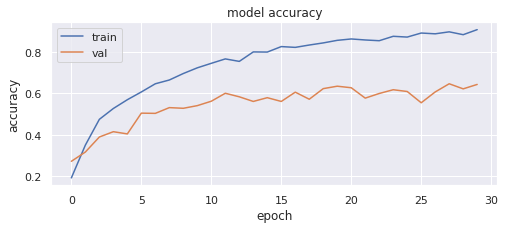

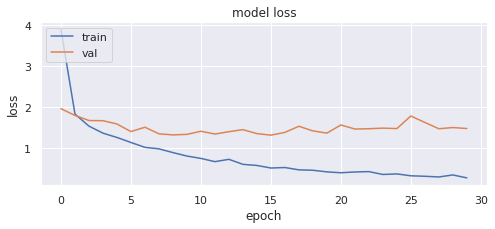

In [148]:
plot_accuracy(history)

In [158]:
test_scores_cnn = test_scores(model)
test_scores_cnn

27/27 [==============================] - 0s 9ms/step - loss: 1.4977 - accuracy: 0.6595


[0.6431623697280884,
 0.6587111949920654,
 0.6687344908714294,
 0.5563725233078003,
 0.6594982147216797]

In [159]:
print((np.mean(test_scores_cnn), np.std(test_scores_cnn)))

(0.6372957587242126, 0.04128668307533861)


In [160]:
score_test = model.evaluate(X_test, y_test)

133/133 [==============================] - 1s 9ms/step - loss: 1.6665 - accuracy: 0.6376


In [161]:
# classification report
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

target_names = list(X_test_df['class'].unique())
target_names.sort() 

print(classification_report(y_test_bool, y_pred_bool, target_names=target_names))

                  precision    recall  f1-score   support

 air_conditioner       0.68      0.42      0.52       500
        car_horn       0.54      0.75      0.62       221
children_playing       0.66      0.65      0.66       500
        dog_bark       0.69      0.78      0.73       500
        drilling       0.48      0.42      0.45       500
   engine_idling       0.63      0.67      0.65       483
        gun_shot       0.90      0.94      0.92       184
      jackhammer       0.52      0.61      0.56       452
           siren       0.70      0.72      0.71       393
    street_music       0.71      0.69      0.70       500

        accuracy                           0.64      4233
       macro avg       0.65      0.66      0.65      4233
    weighted avg       0.64      0.64      0.63      4233



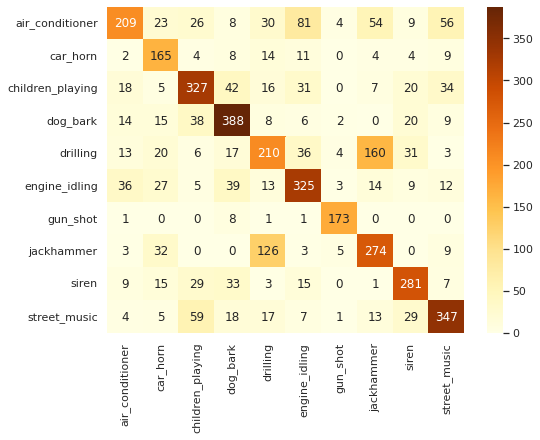

In [164]:
# confusion matrix 

df_cm  = pd.DataFrame(confusion_matrix(y_test_bool, y_pred_bool), range(10), range(10))
plt.figure(figsize= (8,6))
sns.heatmap(df_cm, annot = True,xticklabels= target_names, yticklabels = target_names, cmap ='YlOrBr', fmt='g' )
plt.show()

### FNN

In [188]:
# data reshaping for NN
X_train = X_train.reshape(X_train.shape[0], 480)
X_val = X_val.reshape(X_val.shape[0],480)
X_test7 = X_test7.reshape(X_test7.shape[0],480)
X_test8 = X_test8.reshape(X_test8.shape[0],480)
X_test9 = X_test9.reshape(X_test9.shape[0],480)
X_test10 = X_test10.reshape(X_test10.shape[0],480)
X_test = X_test.reshape(X_test.shape[0],480)

In [189]:
#forming model
model=Sequential()

#building the model
model.add(Dense(units=512,activation='relu',input_dim=480))
model.add(Dropout(0.2))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=10,activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 512)               246272    
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 64)              

In [191]:
#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [192]:
history = model.fit(X_train,y_train,epochs=30 ,batch_size=64, validation_data = (X_val, y_val))

Epoch 1/30
71/71 [==============================] - 2s 13ms/step - loss: 5.8826 - accuracy: 0.1807 - val_loss: 1.9851 - val_accuracy: 0.3269
Epoch 2/30
71/71 [==============================] - 1s 10ms/step - loss: 2.3240 - accuracy: 0.2627 - val_loss: 1.8870 - val_accuracy: 0.3568
Epoch 3/30
71/71 [==============================] - 1s 10ms/step - loss: 1.9968 - accuracy: 0.3554 - val_loss: 1.7109 - val_accuracy: 0.4135
Epoch 4/30
71/71 [==============================] - 1s 10ms/step - loss: 1.7003 - accuracy: 0.4430 - val_loss: 1.5237 - val_accuracy: 0.4509
Epoch 5/30
71/71 [==============================] - 1s 10ms/step - loss: 1.4996 - accuracy: 0.4952 - val_loss: 1.4643 - val_accuracy: 0.4658
Epoch 6/30
71/71 [==============================] - 1s 10ms/step - loss: 1.3412 - accuracy: 0.5595 - val_loss: 1.4371 - val_accuracy: 0.5150
Epoch 7/30
71/71 [==============================] - 1s 10ms/step - loss: 1.2119 - accuracy: 0.5959 - val_loss: 1.3957 - val_accuracy: 0.4658
Epoch 8/30
71

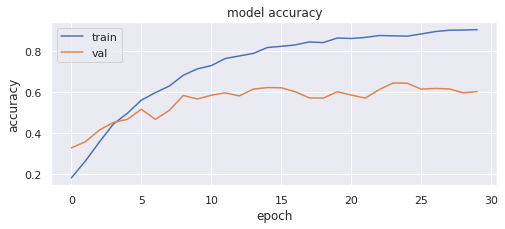

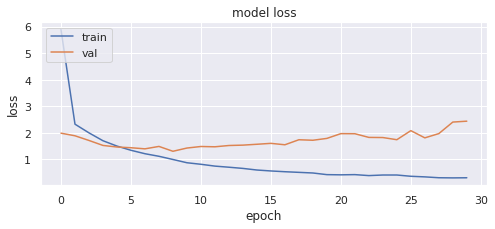

In [193]:
plot_accuracy(history)

In [194]:
test_scores_fnn = test_scores(model)
test_scores_fnn

27/27 [==============================] - 0s 3ms/step - loss: 1.6971 - accuracy: 0.6583


[0.6014957427978516,
 0.6396181583404541,
 0.6290322542190552,
 0.5906862616539001,
 0.658303439617157]

In [195]:
print((np.mean(test_scores_fnn), np.std(test_scores_fnn)))

(0.6238271713256835, 0.024747015287101406)


In [196]:
score_test = model.evaluate(X_test, y_test)

133/133 [==============================] - 0s 3ms/step - loss: 2.0946 - accuracy: 0.6234


In [197]:
# classification report
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

target_names = list(X_test_df['class'].unique())
target_names.sort() 

print(classification_report(y_test_bool, y_pred_bool, target_names=target_names))

                  precision    recall  f1-score   support

 air_conditioner       0.67      0.44      0.53       500
        car_horn       0.79      0.65      0.71       221
children_playing       0.60      0.65      0.63       500
        dog_bark       0.73      0.75      0.74       500
        drilling       0.41      0.45      0.43       500
   engine_idling       0.75      0.66      0.70       483
        gun_shot       0.82      0.93      0.87       184
      jackhammer       0.48      0.51      0.50       452
           siren       0.57      0.77      0.66       393
    street_music       0.67      0.64      0.66       500

        accuracy                           0.62      4233
       macro avg       0.65      0.65      0.64      4233
    weighted avg       0.63      0.62      0.62      4233



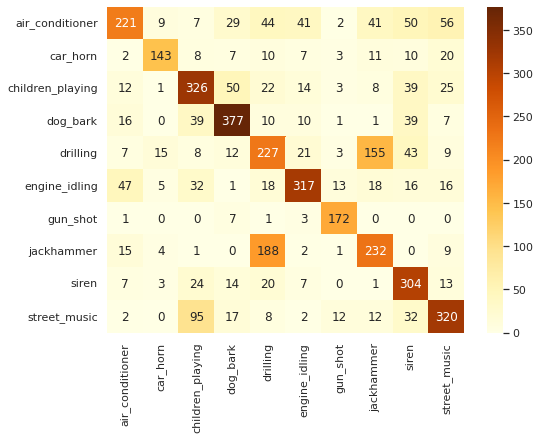

In [198]:
# confusion matrix 

df_cm  = pd.DataFrame(confusion_matrix(y_test_bool, y_pred_bool), range(10), range(10))
plt.figure(figsize= (8,6))
sns.set(font_scale=1)
sns.heatmap(df_cm, annot = True,xticklabels= target_names, yticklabels = target_names, cmap ='YlOrBr', fmt='g' )
plt.show()

### RNN

In [203]:
# data reshaping for RNN
X_train = X_train.reshape(X_train.shape[0],120,4)
X_val = X_val.reshape(X_val.shape[0],120,4)
X_test7 = X_test7.reshape(X_test7.shape[0],120,4)
X_test8 = X_test8.reshape(X_test8.shape[0],120,4)
X_test9 = X_test9.reshape(X_test9.shape[0],120,4)
X_test10 = X_test10.reshape(X_test10.shape[0],120,4)
X_test = X_test.reshape(X_test.shape[0],120,4)

In [227]:
# Neural network model
input_shape = (120,4)

model = Sequential()
model.add(LSTM(128,input_shape=input_shape, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               68096     
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dropout_47 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dropout_49 (Dropout)        (None, 32)              

In [229]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [231]:
history = model.fit(X_train,y_train,epochs=100 ,batch_size=256, validation_data = (X_val, y_val))

Epoch 1/100
18/18 [==============================] - 16s 883ms/step - loss: 1.8855 - accuracy: 0.2881 - val_loss: 1.9871 - val_accuracy: 0.2404
Epoch 2/100
18/18 [==============================] - 16s 869ms/step - loss: 1.8633 - accuracy: 0.2907 - val_loss: 1.9830 - val_accuracy: 0.2415
Epoch 3/100
18/18 [==============================] - 16s 867ms/step - loss: 1.8228 - accuracy: 0.3201 - val_loss: 2.1853 - val_accuracy: 0.1816
Epoch 4/100
18/18 [==============================] - 16s 869ms/step - loss: 1.7977 - accuracy: 0.3250 - val_loss: 2.0059 - val_accuracy: 0.2735
Epoch 5/100
18/18 [==============================] - 16s 864ms/step - loss: 1.7888 - accuracy: 0.3272 - val_loss: 2.1224 - val_accuracy: 0.2137
Epoch 6/100
18/18 [==============================] - 16s 871ms/step - loss: 1.7536 - accuracy: 0.3414 - val_loss: 2.2120 - val_accuracy: 0.2190
Epoch 7/100
18/18 [==============================] - 16s 873ms/step - loss: 1.7539 - accuracy: 0.3387 - val_loss: 1.9009 - val_accuracy:

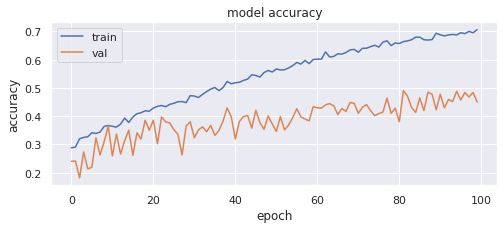

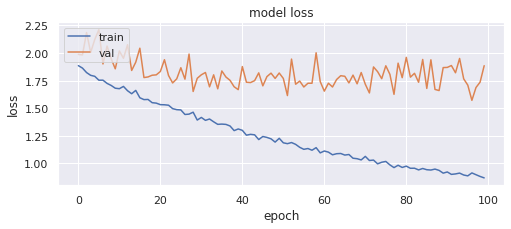

In [232]:
plot_accuracy(history)

In [233]:
test_scores_rnn = test_scores(model)
test_scores_rnn

27/27 [==============================] - 1s 35ms/step - loss: 1.5875 - accuracy: 0.4922


[0.44978633522987366,
 0.5393794775009155,
 0.5210918188095093,
 0.44117647409439087,
 0.49223417043685913]

In [234]:
print((np.mean(test_scores_rnn), np.std(test_scores_rnn)))

(0.48873365521430967, 0.03847826109170287)
